# Lesson4 ニューラル翻訳モデルを作ってみよう（Seq2Seq, Attention）

## 目次

- Section3 Checkクイズの解答
- Section4 実装②
    - 4.0 データの用意
    - 4.1 モデル構築
    - 4.2 モデルの学習
    - 4.3 モデルによる予測
    - 4.4 モデルの可視化
- ケーススタディ

## Section3 Checkクイズの解答

問題1: 4

## Section4 実装②

先程のLSTMを使ったSeq2SeqモデルにAttention機構を導入したうえで英日機械翻訳を行ってみましょう。

### 4.0 データの用意

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_data(file_path):
    tokenizer = Tokenizer(filters="")
    whole_texts = []
    for line in open(file_path, encoding='utf-8'):
        whole_texts.append("<s> " + line.strip() + " </s>")
        
    tokenizer.fit_on_texts(whole_texts)
    
    return tokenizer.texts_to_sequences(whole_texts), tokenizer

# 読み込み＆Tokenizerによる数値化
x_train, tokenizer_en = load_data('/content/gdrive/MyDrive/dl4us/dl4us-master/lesson4/data/train.en')
y_train, tokenizer_ja = load_data('/content/gdrive/MyDrive/dl4us/dl4us-master/lesson4/data/train.ja')

en_vocab_size = len(tokenizer_en.word_index) + 1
ja_vocab_size = len(tokenizer_ja.word_index) + 1

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.02, random_state=42)

# パディング
x_train = pad_sequences(x_train, padding='post')
y_train = pad_sequences(y_train, padding='post')

seqX_len = len(x_train[0])
seqY_len = len(y_train[0])

### 4.1 モデル構築

モデルにAttention機構を導入します。
以下の図のようにDecoder（復号化器）の出力$h_t$に対して、　Encoder（符号化期）の状態を考慮した$\tilde{h_t}$を出力させます。

<img src='figures/attention_model.png'>

Attention機構としてattention $a_t$及び文脈ベクトル$c_t$を用意することに注意して実装してみましょう。

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Permute, Activation, Embedding, Dense, LSTM, concatenate, dot
from tensorflow.keras import backend as K

emb_dim = 256
hid_dim = 256
att_dim = 256

# 符号化器
encoder_inputs = Input(shape=(seqX_len,))
encoder_embedded = Embedding(en_vocab_size, emb_dim, mask_zero=True)(encoder_inputs)
encoded_seq, *encoder_states = LSTM(hid_dim, return_sequences=True, return_state=True)(encoder_embedded)

# 復号化器（encoder_statesを初期状態として指定）
decoder_inputs = Input(shape=(seqY_len,))
decoder_embedding = Embedding(ja_vocab_size, emb_dim)
decoder_embedded = decoder_embedding(decoder_inputs)
decoder_lstm = LSTM(hid_dim, return_sequences=True, return_state=True)
decoded_seq, _, _ = decoder_lstm(decoder_embedded, initial_state=encoder_states)

# Attention
score_dense = Dense(hid_dim)
score = score_dense(decoded_seq)                        # shape: (seqY_len, hid_dim) -> (seqY_len, hid_dim)
score = dot([score, encoded_seq], axes=(2,2))           # shape: [(seqY_len, hid_dim), (seqX_len, hid_dim)] -> (seqY_len, seqX_len)
attention = Activation('softmax')(score)                # shape: (seqY_len, seqX_len) -> (seqY_len, seqX_len)
context = dot([attention, encoded_seq], axes=(2,1))     # shape: [(seqY_len, seqX_len), (seqX_len, hid_dim)] -> (seqY_len, hid_dim)
concat = concatenate([context, decoded_seq], axis=2)    # shape: [(seqY_len, hid_dim), (seqY_len, hid_dim)] -> (seqY_len, 2*hid_dim)
attention_dense = Dense(att_dim, activation='tanh')
attentional = attention_dense(concat)                   # shape: (seqY_len, 2*hid_dim) -> (seqY_len, att_dim)
output_dense = Dense(ja_vocab_size, activation='softmax')
outputs = output_dense(attentional)                     # shape: (seqY_len, att_dim) -> (seqY_len, ja_vocab_size)

model = Model([encoder_inputs, decoder_inputs], outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

### 4.2 モデルの学習

section2と同様にモデルの学習を行います。

In [4]:
import numpy as np

train_target = np.hstack((y_train[:, 1:], np.zeros((len(y_train),1), dtype=np.int32)))

model.fit([x_train, y_train], np.expand_dims(train_target, -1), batch_size=64, epochs=5, verbose=2, validation_split=0.2)

Epoch 1/5
613/613 - 71s - loss: 2.5796 - val_loss: 2.0821
Epoch 2/5
613/613 - 31s - loss: 1.9201 - val_loss: 1.8375
Epoch 3/5
613/613 - 31s - loss: 1.7044 - val_loss: 1.6738
Epoch 4/5
613/613 - 31s - loss: 1.5509 - val_loss: 1.5569
Epoch 5/5
613/613 - 31s - loss: 1.4230 - val_loss: 1.4650


### 4.3 モデルによる生成

生成についてもsection2と同じような仕組みですが、Attentionのモデルで学習していることに注意が必要です。

In [5]:
encoder_model = Model(encoder_inputs, [encoded_seq]+encoder_states)

decoder_states_inputs = [Input(shape=(hid_dim,)), Input(shape=(hid_dim,))]

decoder_inputs = Input(shape=(1,))
decoder_embedded = decoder_embedding(decoder_inputs)
decoded_seq, *decoder_states = decoder_lstm(decoder_embedded, initial_state=decoder_states_inputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoded_seq] + decoder_states)

# Attention
encoded_seq_in, decoded_seq_in = Input(shape=(seqX_len, hid_dim)), Input(shape=(1, hid_dim))
score = score_dense(decoded_seq_in)
score = dot([score, encoded_seq_in], axes=(2,2))
attention = Activation('softmax')(score)
context = dot([attention, encoded_seq_in], axes=(2,1))
concat = concatenate([context, decoded_seq_in], axis=2)
attentional = attention_dense(concat)
attention_outputs = output_dense(attentional)

attention_model = Model([encoded_seq_in, decoded_seq_in], [attention_outputs, attention])

このモデルを使用した生成（予測）を行ってみましょう。

In [6]:
def decode_sequence(input_seq, bos_eos, max_output_length = 1000):
    encoded_seq, *states_value = encoder_model.predict(input_seq)

    target_seq = np.array(bos_eos[0])  # bos_eos[0]="<s>"に対応するインデックス
    output_seq = bos_eos[0][:]
    attention_seq = np.empty((0,len(input_seq[0])))
    
    while True:
        decoded_seq, *states_value = decoder_model.predict([target_seq] + states_value)
        output_tokens, attention = attention_model.predict([encoded_seq, decoded_seq])
        sampled_token_index = [np.argmax(output_tokens[0, -1, :])]
        output_seq += sampled_token_index
        attention_seq = np.append(attention_seq, attention[0], axis=0)
        
        if (sampled_token_index == bos_eos[1] or len(output_seq) > max_output_length):
            break

        target_seq = np.array(sampled_token_index)

    return output_seq, attention_seq

In [7]:
%matplotlib inline 
import matplotlib.pyplot as plt

detokenizer_en = dict(map(reversed, tokenizer_en.word_index.items()))
detokenizer_ja = dict(map(reversed, tokenizer_ja.word_index.items()))

text_no = 0
input_seq = pad_sequences([x_test[text_no]], seqX_len, padding='post')
bos_eos = tokenizer_ja.texts_to_sequences(["<s>", "</s>"])

output_seq, attention_seq = decode_sequence(input_seq, bos_eos)

print('元の文:', ' '.join([detokenizer_en[i] for i in x_test[text_no]]))
print('生成文:', ' '.join([detokenizer_ja[i] for i in output_seq]))
print('正解文:', ' '.join([detokenizer_ja[i] for i in y_test[text_no]]))

元の文: <s> you may extend your stay in tokyo . </s>
生成文: <s> あなた は この バス を 使 っ て も い い 。 </s>
正解文: <s> 東京 滞在 を 延ば し て も い い で す よ 。 </s>


ここではさらに、Attentionの分布も描画してみましょう。（環境によっては、縦軸の日本語ラベルが文字化けするかもしれません）

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12394 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12383 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12399 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12371 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_

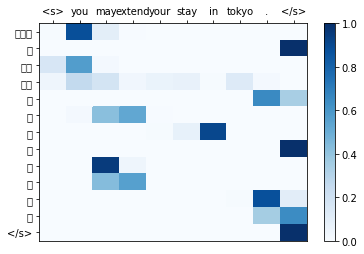

In [8]:
# 描画
fig, ax = plt.subplots()
heatmap = ax.pcolor(attention_seq[:,:len(x_test[text_no])], cmap=plt.cm.Blues, vmax=1)
ax.set_xticks(np.arange(len(x_test[text_no])) + 0.5, minor=False)
ax.set_yticks(np.arange(attention_seq.shape[0]) + 0.5, minor=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.set_xticklabels([detokenizer_en[i] for i in x_test[text_no]], minor=False)
ax.set_yticklabels([detokenizer_ja[i] for i in output_seq[1:]], minor=False)
plt.colorbar(heatmap)
plt.show()

### 4.4 モデルの可視化

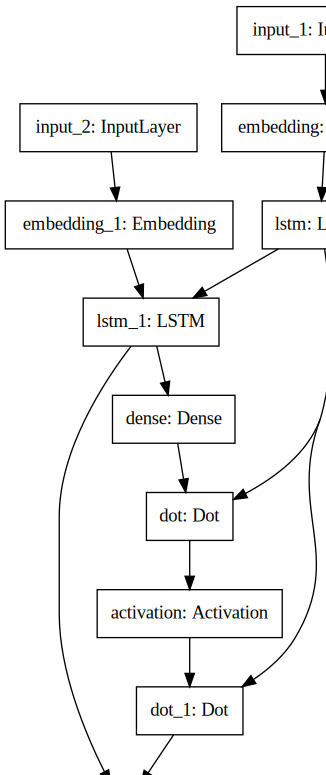

In [9]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))